In [22]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from geopandas import GeoDataFrame
# from shapely.geometry import Point, Polygon
from shapely import wkt
from scipy.spatial import cKDTree
import geoplot as gpt
import geoplot.crs as gcrs

## Preparing DataFrame with climate risk geodata (gdf) and company locations (cdf)

In [90]:
gdf = pd.read_csv('rus.csv')
gdf['geometry'] = gdf['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(gdf, crs={'init': 'epsg:4326'}, geometry='geometry')
gdf

/Users/ivannovikov/Documents/Code/PythonProjects/spark/env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,geometry,timestamp,prob
0,POINT (27.00000 47.66325),2024-01-01,0.0
1,POINT (27.00000 47.66325),2024-02-01,0.0
2,POINT (27.00000 47.66325),2024-03-01,0.0
3,POINT (27.00000 47.66325),2024-04-01,0.0
4,POINT (27.00000 47.66325),2024-05-01,0.0
...,...,...,...
9770,POINT (155.25000 65.60686),2024-01-01,0.0
9771,POINT (155.25000 65.60686),2024-02-01,0.0
9772,POINT (155.25000 65.60686),2024-03-01,0.0
9773,POINT (155.25000 65.60686),2024-04-01,0.0


<Axes: >

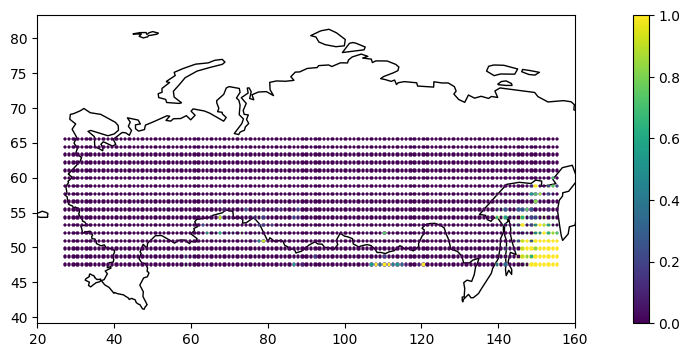

In [89]:
world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)
russia = world.loc[world['name'] == 'Russia']

fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.set_xlim(20, 160)
base = russia.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=base, column='prob', marker='s', s=1, legend=True)

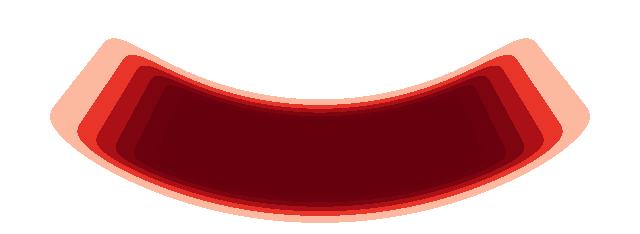

In [100]:
gdf_cut = gdf.drop(columns='timestamp')
ax = gpt.kdeplot(gdf_cut, projection=gcrs.AlbersEqualArea(), cmap='Reds', fill=True)

In [50]:
cdf = pd.read_csv('company_fin_df.csv')
cdf = cdf[['inn', 'short_name', 'full_name', 'region', 'city', 'latitude', 'longitude']]
cdf = gpd.GeoDataFrame(cdf, geometry=gpd.points_from_xy(cdf.longitude, cdf.latitude))
cdf = cdf.drop(columns=['longitude', 'latitude'])
cdf

,inn,short_name,full_name,region,city,geometry
0,7736050003,NaN,ГАЗПРОМ ОАО,15,ГОРОД ВЛАДИКАВКАЗ,POINT (44.68211 43.02459)
1,5504036333,ООО &quot;ГАЗПРОМНЕФТЬ-УРАЛ (НБ)&quot;,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ &quot...,66,ГОРОД ЕКАТЕРИНБУРГ,POINT (60.64942 56.82110)
2,5504036333,ООО &quot;ГАЗПРОМНЕФТЬ-УРАЛ (АЗС)&quot;,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ &quot...,66,ГОРОД ЕКАТЕРИНБУРГ,POINT (60.64942 56.82110)
3,5504036333,ООО &quot;МАЛО-ЯМАЛЬСКОЕ&quot;,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ &quot...,89,ГОРОД НОВЫЙ УРЕНГОЙ,POINT (76.68652 66.09226)
4,8602060555,ПАО &quot;СУРГУТНЕФТЕГАЗ&quot;,ПУБЛИЧНОЕ АКЦИОНЕРНОЕ ОБЩЕСТВО &quot;СУРГУТНЕФ...,86,Г. СУРГУТ,POINT (73.36774 61.25070)
...,...,...,...,...,...,...
5008,6829045090,ООО &quot;РАЙ&quot;,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ &quot...,68,Г. ТАМБОВ,POINT (41.45320 52.72478)
5009,4027131618,ООО &quot;МАНУФАКТУРЫ БОСКО&quot;,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ &quot...,40,Г. КАЛУГА,POINT (36.28477 54.53698)
5010,6452109727,ООО &quot;НИТА-ФАРМ&quot;,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ &quot...,64,Г. САРАТОВ,POINT (47.81068 52.00523)
5011,5204012980,ООО &quot;ННПП-2&quot;,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ &quot...,52,NaN,POINT (44.77632 55.78375)


<Axes: >

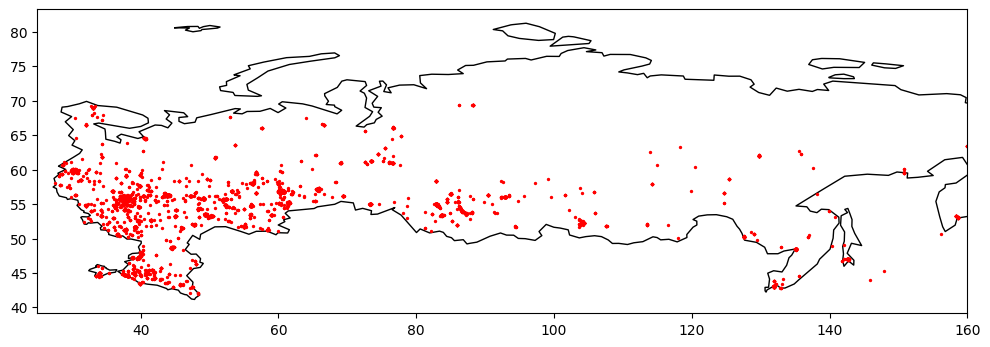

In [74]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 4))
ax1.set_xlim(25, 160)
base = russia.plot(ax=ax1, color='white', edgecolor='black')
cdf.plot(ax=base, markersize=2, color='red')

## Matching nearest points with climate data to company locations

In [54]:
def ckdnearest(gdA, gdB):
    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdB_nearest = gdB_nearest.rename('nearest_point')
    dist = pd.Series(dist, name='distance')

    return pd.concat([cdf, gdB_nearest, dist], axis=1)

points = gdf['geometry'].drop_duplicates()
cmap = ckdnearest(cdf, points)
cmap

,inn,short_name,full_name,region,city,geometry,nearest_point,distance
0,7736050003,NaN,ГАЗПРОМ ОАО,15,ГОРОД ВЛАДИКАВКАЗ,POINT (44.68211 43.02459),POINT (45.00000 47.66325),4.649537
1,5504036333,ООО &quot;ГАЗПРОМНЕФТЬ-УРАЛ (НБ)&quot;,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ &quot...,66,ГОРОД ЕКАТЕРИНБУРГ,POINT (60.64942 56.82110),POINT (60.75000 56.63509),0.211464
2,5504036333,ООО &quot;ГАЗПРОМНЕФТЬ-УРАЛ (АЗС)&quot;,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ &quot...,66,ГОРОД ЕКАТЕРИНБУРГ,POINT (60.64942 56.82110),POINT (60.75000 56.63509),0.211464
3,5504036333,ООО &quot;МАЛО-ЯМАЛЬСКОЕ&quot;,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ &quot...,89,ГОРОД НОВЫЙ УРЕНГОЙ,POINT (76.68652 66.09226),POINT (76.50000 65.60686),0.520001
4,8602060555,ПАО &quot;СУРГУТНЕФТЕГАЗ&quot;,ПУБЛИЧНОЕ АКЦИОНЕРНОЕ ОБЩЕСТВО &quot;СУРГУТНЕФ...,86,Г. СУРГУТ,POINT (73.36774 61.25070),POINT (73.12500 61.12099),0.275227
...,...,...,...,...,...,...,...,...
5008,6829045090,ООО &quot;РАЙ&quot;,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ &quot...,68,Г. ТАМБОВ,POINT (41.45320 52.72478),POINT (41.62500 53.27066),0.572279
5009,4027131618,ООО &quot;МАНУФАКТУРЫ БОСКО&quot;,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ &quot...,40,Г. КАЛУГА,POINT (36.28477 54.53698),POINT (36.00000 54.39214),0.319486
5010,6452109727,ООО &quot;НИТА-ФАРМ&quot;,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ &quot...,64,Г. САРАТОВ,POINT (47.81068 52.00523),POINT (47.25000 52.14917),0.578866
5011,5204012980,ООО &quot;ННПП-2&quot;,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ &quot...,52,NaN,POINT (44.77632 55.78375),POINT (45.00000 55.51361),0.350727


## Filtering by distance to reference points
## and averaging climate risks by time

In [63]:
cmap_dist = cmap.loc[cmap['distance'] <= 1]
print(f' Number of Companies in range of reference points {cmap_dist.shape[0]} / {cmap.shape[0]}')

 Number of Companies in range of reference points 4286 / 5013


In [64]:
from tqdm import tqdm

def avg_by_time(cmap, rmap):
    nearest_p = cmap['nearest_point'].unique()
    res = np.zeros(nearest_p.shape[0])
    for i in tqdm(range(nearest_p.shape[0])):
        avg_prob = rmap[rmap['geometry'] == nearest_p[i]].prob.mean()
        res[i] = avg_prob
    return nearest_p, res

near_p, prob = avg_by_time(cmap_dist, gdf)

100%|██████████| 326/326 [00:28<00:00, 11.50it/s]


                    geometry  avg_prob
0  POINT (60.75000 56.63509)       0.0
1  POINT (76.50000 65.60686)       0.0
2  POINT (73.12500 61.12099)       0.0
3  POINT (74.25000 62.24246)       0.0
4  POINT (52.87500 54.39214)       0.0


<Axes: >

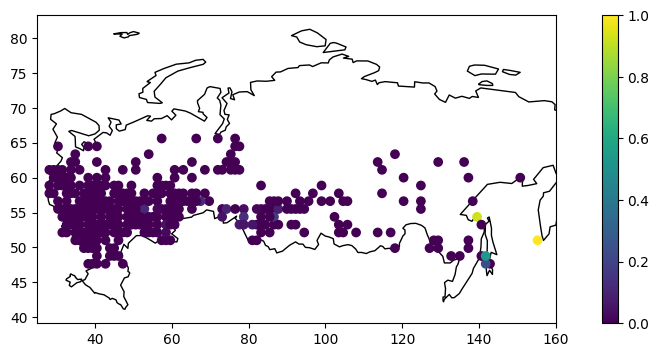

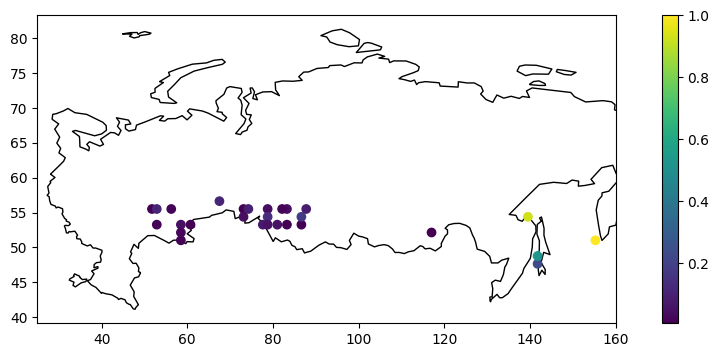

In [67]:
pdf = gpd.GeoDataFrame({'geometry': near_p, 'avg_prob': prob})
print(pdf.head())

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.set_xlim(25, 160)
base = russia.plot(ax=ax, color='white', edgecolor='black')

pdf.plot(column = 'avg_prob', legend=True, ax=base)
pdf = pdf[pdf['avg_prob'] > 0.0]

fig, ax1 = plt.subplots(1, 1, figsize=(12, 4))
ax1.set_xlim(25, 160)
base1 = russia.plot(ax=ax1, color='white', edgecolor='black')
pdf.plot(column = 'avg_prob', legend=True, ax=base1)

## Joining companies DataFrame with climate probabilities

In [51]:
timestamps = gdf['timestamp'].unique()
geo = gdf[gdf['timestamp'] == timestamps[0]].geometry.reset_index()
df_list = [geo.drop(columns='index')]
for time in timestamps:
    temp_df = gdf[gdf['timestamp'] == time]
    temp_df = temp_df.reset_index()
    temp_df = temp_df.drop(columns=['timestamp', 'geometry', 'index'])
    temp_df = temp_df.rename(columns={'prob' : 'prob'+time})
    df_list.append(temp_df)
    
gdf_agg = pd.concat(df_list, axis=1)
gdf_agg

,geometry,prob2024-01-01,prob2024-02-01,prob2024-03-01,prob2024-04-01,prob2024-05-01
0,POINT (27.00000 47.66325),0.0,0.0,0.0,0.0,0.0
1,POINT (28.12500 47.66325),0.0,0.0,0.0,0.0,0.0
2,POINT (29.25000 47.66325),0.0,0.0,0.0,0.0,0.0
3,POINT (30.37500 47.66325),0.0,0.0,0.0,0.0,0.0
4,POINT (31.50000 47.66325),0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
1950,POINT (150.75000 65.60686),0.0,0.0,0.0,0.0,0.0
1951,POINT (151.87500 65.60686),0.0,0.0,0.0,0.0,0.0
1952,POINT (153.00000 65.60686),0.0,0.0,0.0,0.0,0.0
1953,POINT (154.12500 65.60686),0.0,0.0,0.0,0.0,0.0


In [52]:
nearest_points = cmap['nearest_point']
ref_points = gdf_agg['geometry']
probs_list = []
for p in tqdm(nearest_points):
    x = p.x
    y = p.y
    for i in range(len(ref_points)):
        rp = ref_points[i]
        if (rp.x == x) & (rp.y == y):
            probs_list.append(gdf_agg.iloc[i])
            
probs_df = pd.concat(probs_list, axis=1).T
probs_df = probs_df.reset_index()
probs_df = probs_df.drop(columns=['index', 'geometry'])
probs_df

100%|██████████| 5013/5013 [01:30<00:00, 55.56it/s]


,prob2024-01-01,prob2024-02-01,prob2024-03-01,prob2024-04-01,prob2024-05-01
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
5008,0.0,0.0,0.0,0.0,0.0
5009,0.0,0.0,0.0,0.0,0.0
5010,0.0,0.0,0.0,0.0,0.0
5011,0.0,0.0,0.0,0.0,0.0


In [55]:
cprob_map = pd.concat([cmap, probs_df], axis=1)
cprob_map.to_csv('cp_wind_test.csv')
cprob_map

,inn,short_name,full_name,region,city,geometry,nearest_point,distance,prob2024-01-01,prob2024-02-01,prob2024-03-01,prob2024-04-01,prob2024-05-01
0,7736050003,NaN,ГАЗПРОМ ОАО,15,ГОРОД ВЛАДИКАВКАЗ,POINT (44.68211 43.02459),POINT (45.00000 47.66325),4.649537,0.0,0.0,0.0,0.0,0.0
1,5504036333,ООО &quot;ГАЗПРОМНЕФТЬ-УРАЛ (НБ)&quot;,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ &quot...,66,ГОРОД ЕКАТЕРИНБУРГ,POINT (60.64942 56.82110),POINT (60.75000 56.63509),0.211464,0.0,0.0,0.0,0.0,0.0
2,5504036333,ООО &quot;ГАЗПРОМНЕФТЬ-УРАЛ (АЗС)&quot;,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ &quot...,66,ГОРОД ЕКАТЕРИНБУРГ,POINT (60.64942 56.82110),POINT (60.75000 56.63509),0.211464,0.0,0.0,0.0,0.0,0.0
3,5504036333,ООО &quot;МАЛО-ЯМАЛЬСКОЕ&quot;,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ &quot...,89,ГОРОД НОВЫЙ УРЕНГОЙ,POINT (76.68652 66.09226),POINT (76.50000 65.60686),0.520001,0.0,0.0,0.0,0.0,0.0
4,8602060555,ПАО &quot;СУРГУТНЕФТЕГАЗ&quot;,ПУБЛИЧНОЕ АКЦИОНЕРНОЕ ОБЩЕСТВО &quot;СУРГУТНЕФ...,86,Г. СУРГУТ,POINT (73.36774 61.25070),POINT (73.12500 61.12099),0.275227,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5008,6829045090,ООО &quot;РАЙ&quot;,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ &quot...,68,Г. ТАМБОВ,POINT (41.45320 52.72478),POINT (41.62500 53.27066),0.572279,0.0,0.0,0.0,0.0,0.0
5009,4027131618,ООО &quot;МАНУФАКТУРЫ БОСКО&quot;,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ &quot...,40,Г. КАЛУГА,POINT (36.28477 54.53698),POINT (36.00000 54.39214),0.319486,0.0,0.0,0.0,0.0,0.0
5010,6452109727,ООО &quot;НИТА-ФАРМ&quot;,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ &quot...,64,Г. САРАТОВ,POINT (47.81068 52.00523),POINT (47.25000 52.14917),0.578866,0.0,0.0,0.0,0.0,0.0
5011,5204012980,ООО &quot;ННПП-2&quot;,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ &quot...,52,NaN,POINT (44.77632 55.78375),POINT (45.00000 55.51361),0.350727,0.0,0.0,0.0,0.0,0.0
